In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Reshape
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dense, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Reshape, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Layer

In [2]:
def load_images(folder_path, image_size=(64,64)):
    data = []
    labels = []

    label = os.path.basename(folder_path)  # Extract the label from the folder name

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):  # Check if it is a file
            img = cv2.imread(img_path)
            if img is not None:  # Check if the image was read correctly
                img = cv2.resize(img, image_size)  # Resize images to a common size
                data.append(img)
                labels.append(label)

    return np.array(data), np.array(labels)

dataset_path = r"E:\Dataset\Alzheimer's Dataset ( 4 class of Images)\Aug"

# Load images for each type of chest X-ray
data_MildDemented, labels_MildDemented = load_images(os.path.join(dataset_path, 'MildDemented'))
data_ModerateDemented, labels_ModerateDemented = load_images(os.path.join(dataset_path, 'ModerateDemented'))
data_NonDemented, labels_NonDemented = load_images(os.path.join(dataset_path, 'NonDemented'))
data_VeryMildDemented, labels_VeryMildDemented = load_images(os.path.join(dataset_path, 'VeryMildDemented'))

In [3]:
data_MildDemented.shape

(3500, 64, 64, 3)

In [4]:
# Combine data and labels for all tumor types
All_data = np.concatenate([data_MildDemented, data_ModerateDemented, data_NonDemented,data_VeryMildDemented])
All_labels = np.concatenate([labels_MildDemented, labels_ModerateDemented, labels_NonDemented,  labels_VeryMildDemented])

In [5]:
All_data.shape

(14000, 64, 64, 3)

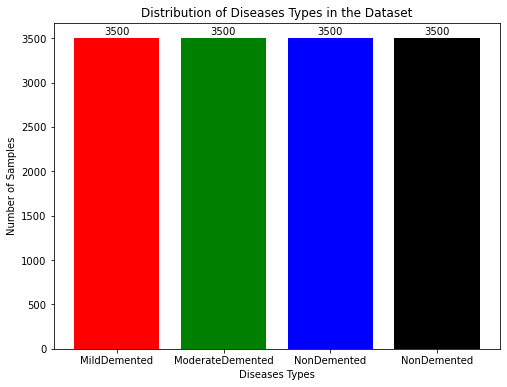

In [6]:
unique_labels, label_counts = np.unique(All_labels, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, label_counts, color=['red', 'green', 'blue', 'black'])
plt.xlabel('Diseases Types')
plt.ylabel('Number of Samples')
plt.title('Distribution of Diseases Types in the Dataset')
for i, count in enumerate(label_counts):
    plt.text(i, count + 20, str(count), ha='center', va='bottom')

plt.xticks(unique_labels, ['MildDemented', 'ModerateDemented', 'NonDemented', 'NonDemented' ])
plt.show()

In [7]:
# Normalize Pixel Values
All_data_normalized = All_data / 255.0

In [8]:
# Encode Labels
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(All_labels)
train_data, test_data, train_labels, test_labels = train_test_split(
    All_data_normalized, all_labels_encoded, test_size=0.15, random_state=42
)

In [10]:
image_size = (64, 64)
num_classes = 4

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = tf.nn.tanh(tf.tensordot(x, self.W, axes=(2, 0)) + self.b)
        at = tf.nn.softmax(et, axis=1)
        ot = x * at
        return tf.reduce_sum(ot, axis=1)

In [13]:
from tensorflow.keras.models import Model
inputs = Input(shape=(image_size + (3,)))

# CNN layers with Dropout
x = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)  # Adding Dropout after the first max pooling layer
x = Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)  # Adding Dropout after the second max pooling layer
x = Flatten()(x)

# Reshape the output to fit the LSTM input
x = Reshape((1, -1))(x)

# Single LSTM layer with Dropout
lstm_out = LSTM(50, return_sequences=True)(x)
lstm_out = Dropout(0.3)(lstm_out)  # Adding Dropout after LSTM layer

# Attention mechanism
attention_output = Attention()(lstm_out)

# Skip connection to final dense layer
combined_output = Add()([attention_output, tf.reduce_sum(lstm_out, axis=1)])

# Final dense layer
outputs = Dense(num_classes, activation="softmax")(combined_output)

# Define the combined model
combined_model = Model(inputs=inputs, outputs=outputs)

# Compile the model
combined_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Callbacks
checkpoint_callback = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
early_stopping_callback = EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)

# Model summary
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 62, 62, 16)           448       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 16)           0         ['conv2d_2[0][0]']            
 g2D)                                                                                             
                                                                                                  
 dropout_3 (Dropout)         (None, 31, 31, 16)           0         ['max_pooling2d_2[0][0]'] 

In [14]:
# Train the model with callbacks
history = combined_model.fit(
    train_data,
    train_labels,
    epochs=30,
    batch_size=16,
    validation_split=0.15,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/30
633/633 [==============================] - 29s 42ms/step - loss: 0.9270 - accuracy: 0.5846 - val_loss: 0.6173 - val_accuracy: 0.7160
Epoch 2/30


C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


633/633 [==============================] - 27s 43ms/step - loss: 0.5568 - accuracy: 0.7546 - val_loss: 0.4511 - val_accuracy: 0.8101
Epoch 3/30
633/633 [==============================] - 27s 43ms/step - loss: 0.4567 - accuracy: 0.8012 - val_loss: 0.3778 - val_accuracy: 0.8504
Epoch 4/30
633/633 [==============================] - 27s 43ms/step - loss: 0.3793 - accuracy: 0.8399 - val_loss: 0.3184 - val_accuracy: 0.8734
Epoch 5/30
633/633 [==============================] - 27s 43ms/step - loss: 0.3230 - accuracy: 0.8644 - val_loss: 0.2577 - val_accuracy: 0.9098
Epoch 6/30
633/633 [==============================] - 26s 42ms/step - loss: 0.2759 - accuracy: 0.8910 - val_loss: 0.2281 - val_accuracy: 0.9171
Epoch 7/30
633/633 [==============================] - 25s 39ms/step - loss: 0.2312 - accuracy: 0.9061 - val_loss: 0.2000 - val_accuracy: 0.9345
Epoch 8/30
633/633 [==============================] - 25s 40ms/step - loss: 0.2053 - accuracy: 0.9181 - val_loss: 0.1625 - val_accuracy: 0.9440
Epo

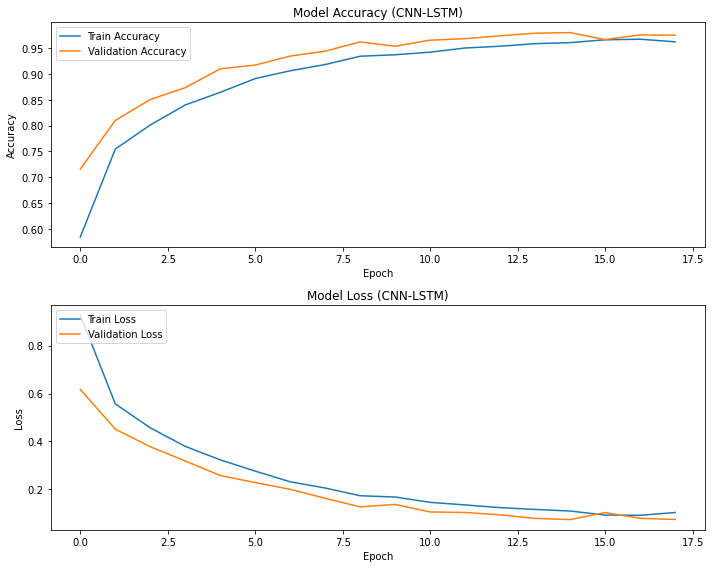

In [15]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot Accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy (CNN-LSTM)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='upper left')

# Plot Loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss (CNN-LSTM)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
# Evaluate the model on the test set
test_predictions1 = combined_model.predict(test_data)
test_predictions_classes1 = np.argmax(test_predictions1, axis=1)
CNN_LSTM_class_report1 = classification_report(test_labels, test_predictions_classes1, target_names=label_encoder.classes_)
print("Classification Report:\n", CNN_LSTM_class_report1)

66/66 [==============================] - 1s 14ms/step
Classification Report:
                   precision    recall  f1-score   support

    MildDemented       0.96      0.99      0.97       527
ModerateDemented       1.00      0.99      1.00       530
     NonDemented       0.98      0.98      0.98       530
VeryMildDemented       0.97      0.95      0.96       513

        accuracy                           0.98      2100
       macro avg       0.98      0.98      0.98      2100
    weighted avg       0.98      0.98      0.98      2100



In [17]:
accuracy = accuracy_score(test_labels, test_predictions_classes1)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 97.76%


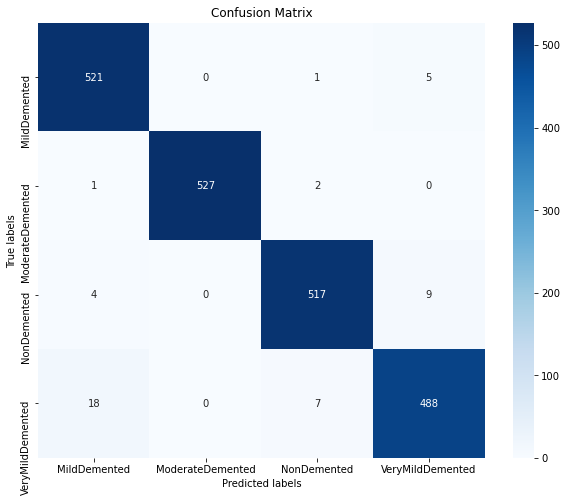

In [18]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_classes1)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
#combined_model.save("trained_combined_model_attention.h5")

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
